# Getting started with NLP - A general Introudction
이 노트북은 캐글 노트북 [Getting started with NLP - A general Introudction](https://www.kaggle.com/code/parulpandey/getting-started-with-nlp-a-general-intro/notebook)을 베낀 것입니다.  

이 노트북은 이사람이 'Getting Started with NLP Notebooks'라고 쓰고 있는 것의 첫번째 글이라고 하네요. 이 사람은 
>NLP가 인간 언어와 컴퓨터 과학, 인공지능, computational linguistics 사이의 상호작용에 대해 연구하는 분야
(영어 위키피디아)  
이걸 인용하면서 분위기를 잡습니다.  

## Evaluation Metrics  
여기서는 제출용으로 F1 score를 쓸 거라고 합니다.  
${\it F}_1 = 2 \times \frac{precision \times recall}{precision + recall}$  
where  
$precision = \frac{TP}{TP+FP} \\
recall = \frac{TP}{TP+FN}$  
자세한 설명은 생략하겠습니다.  

F score는 precision, recall이 모두 perfect할 때 1, 모두 완전히 틀렸을 때 0이 됩니다. 조화평균이기도 합니다.  
search, 문서 분류, query classification에 보통 쓰인다고 해요. 이것도 또 출처를 써놨습니다.
https://deepai.org/machine-learning-glossary-and-terms/f-score

# Importing Neccesary Libraries

In [21]:
import numpy as np
import pandas as pd

# text processing libraries
import re
import string
import nltk #natual language toolkit
from nltk.corpus import stopwords

#Importing too many libraries. I'll skip explanation on them at this stage
#XGBoost: 
import xgboost as xgb
from xgboost import XGBClassifier

#sklearn: 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

#to plot figure
import matplotlib.pyplot as plt
import seaborn as sns

#others
import os
import warnings
warnings.filterwarnings('ignore')



# 2. 데이터셋 불러오기

In [22]:
#list files, load data
print(os.listdir("../input/nlp-getting-started"))

['sample_submission.csv', 'train.csv', 'test.csv']


In [23]:
#load training data
path = "../input/nlp-getting-started"
train = pd.read_csv(os.path.join(path, 'train.csv'))
print(train.shape)
train.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


disaster tweet이라고 했는데 target은 어떤 의미였죠ㅕ?

In [24]:
#load test data 
test = pd.read_csv(os.path.join(path, 'test.csv'))
print(test.shape)
test.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 3. 기본적인 EDA

In [25]:
#missing values
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [26]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Location에서 null값이 많아요.

## Target 열 살펴보기
이 열은 disaster에 대한 트윗인지 아닌지를 담고 있습니다. True: 1, False: 0

In [27]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot:ylabel='target'>

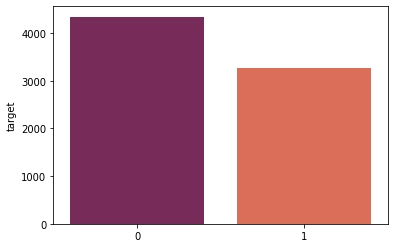

In [28]:
sns.barplot(train.target.value_counts().index, train.target.value_counts(),palette='rocket')

상당히 비슷한 숫자로 구성돼 있네요. 한번 내용을 살펴봅시다.

In [29]:
#disaster tweets
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.sample(5).values

array(['#BreakingNews Militants attack Udhampur police post; 2 SPOs injured http://t.co/EqCCrTlnbd',
       "Jrowah: Breaking news! Unconfirmed! I just heard a loud bang nearby. in what appears to be a blast of wind from my neighbour's ass.",
       'After the green line derailment my concern for track that looks like this goes up a bit... @cta @CTAFails http://t.co/1uDz0NVOEH',
       'To All The Meat-Loving Feminists Of The World Riot Grill Has Arrived http://t.co/TiOst8oKvX',
       "First time getting into #gbbo2015 and physically gasped at the cake 'mudslide' incident already way too emotionally invested..."],
      dtype=object)

In [30]:
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.sample(5).values

array(['i lava you! ????',
       '@mustachemurse @dateswhitecoats the truth. I pulled a 16 out. And apparently a 22 in the crazy adult trauma. And they mocked me for the 22.',
       "If there's a chance will get a gander of the sinking ship that is #TNA too. Can't help but appease my morbid curiosity. #DestinationIMPACT",
       'fresh out da shower lookss ?? (still loving this new hair does it ruin my brand?) #yes https://t.co/T2Kk8fya77',
       "If I can't ruin his mood then I may have lost my direction. https://t.co/sLc27EMUgM"],
      dtype=object)

## 키워드 칼럼 살펴보기
이게 혹시 태그인가요? 잘 모르겠네요.

<AxesSubplot:xlabel='keyword'>

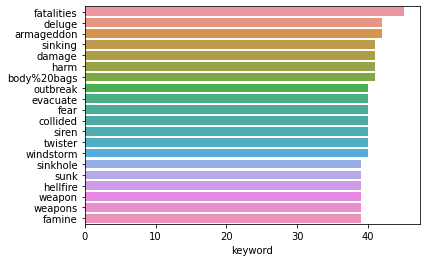

In [31]:
sns.barplot(y=train.keyword.value_counts()[:20].index, x=train.keyword.value_counts()[:20],
           orient='h')

'disaster'라는 단어가 나오는 것과 target column과의 상관관계를 알아봅니다.

In [32]:
train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()
#na : If true, fill missing values
#case : means case sensitive

1    102
0     40
Name: target, dtype: int64

# Location 열 살펴보기
missing value가 많지만 그래도 살펴봅니다. 쓸려면 cleaning이 필요할 것 같다네요.

<AxesSubplot:xlabel='location'>

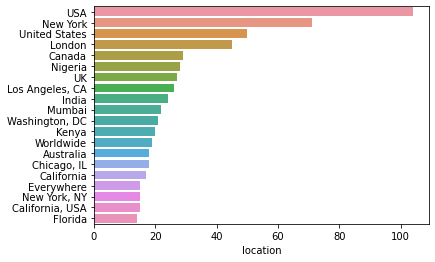

In [13]:
sns.barplot(y=train['location'].value_counts()[:20].index, x=train['location'].value_counts()[:20],
           orient='h')

# 4. 텍스트 전처리
clean, tokenize, convert into matrix 할 겁니다.
## 1. Data Cleaning
- lower case로 통일
- 노이즈로 보는, 구두점, 숫자, common non-sensical text 제거
- Tokenize
- stopword removal
### 추가적인 data cleaning 처리 (토큰화 이후)
- stemming : 비슷한 단어를 합칩니다.
- Lemmatization : Stemming이랑 비슷한데 stemming 은 없던 단어를 만들지만 여기서는 있던 단어로 통합합니다.
- parts of speech tagging: 뭔소린지 모르겠네요. 쌍따옴표 같은 걸 표시하는지 아니면 구어체를 분리하는지
- bi-grams or tri-grams 등등 만들기 : 연속된 element 여러개를 묶어서 잘라 보는 것을 -grams라고 하죠.  

그런데 다 할 필요는 없다면서 다음 글을 인용합니다. [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial/#.Xi2BhhczZTY)


In [33]:
# glance at
train['text'].sample(5)

4419    Mom is hijacking my account to earn MCR STATUS...
6455    Turkish troops killed in Kurdish militant 'sui...
1484    .@AIGinsurance CEO: Divestitures and #Catastro...
5182    @horiikawa i played online last night and got ...
586     FedEx not willing to transport research specim...
Name: text, dtype: object

In [34]:
# first round of text cleaning

def clean_text(text):
    '''Make text lowercase, remove text in square brackes, remove lines, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]','',text) #remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+','',text)
    #delete hyperlinks: '?' in re means it appears 1 or 0 time. '\S' means every non-whitespace characeter
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

#apply
train['text']=train['text'].apply(clean_text)
test['text']=test['text'].apply(clean_text)

#check results
train['text']
    

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3        people receive wildfires evacuation orders in...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610                                 s of volcano hawaii 
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

### regular expressions 의미 파악해보기
https://docs.python.org/ko/3/howto/regex.html 을 참고합니다. 정규 표현식에서는 메타 문자라는 것들이 정해져 여러 기능을 수행합니다.  
\[\](square bracket)는 문자 집합을 표현하고 -(하이픈)을 이용해 범위를 지정하거나 ^(캐럿)를 이용해 여집합을 설정할 수 있습니다. \ (백 슬래시)는  메타 문자를 표시할 때 앞에 붙여 쓸 수 있고, \w 같은 특수 시퀀스는 미리 정의된 문자 집합을 의미합니다. \w 는 영어 알파벳+숫자입니다. (alphanumeric character)  
\*(애스터뭐시기)은 반복을 표시합니다. \+ 도 반복을 뜻하지만 1번 이상 패턴이 일치할 것을 요구합니다.  
다른 반복 한정자(qualifier)로 \?는 한 번이나 0번 일치합니다. 없거나 한 번 등장하는 경우를 뜻합니다.  
{m,n}도 반복 한정자인데 있는데 최소 m번, 최대 n번 반복되는 경우라고 합니다.  

__wordcolud는 별로 fun하지 않아서 생략합니다.__
# 2. Tokenization  
tokenization의 여러가지 유형을 알아봅니다.

In [35]:
text = "Are you coming, aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer1.tokenize(text)
#by whitespace


['Are', 'you', 'coming,', "aren't", 'you']

In [36]:
tker2=nltk.tokenize.TreebankWordTokenizer()
tker2.tokenize(text)
#by words using Treebank


['Are', 'you', 'coming', ',', 'are', "n't", 'you']

In [37]:
tker3=nltk.tokenize.WordPunctTokenizer()
tker3.tokenize(text)
#by punctuation

['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']

In [38]:
tker4=nltk.tokenize.RegexpTokenizer(r'\w+')
tker4.tokenize(text)
#by regular expression. '\w' for every alphanumeric character

['Are', 'you', 'coming', 'aren', 't', 'you']

In [48]:
## Tokeninize dataset
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text']=train['text'].apply(tokenizer.tokenize)
test['text']=test['text'].apply(tokenizer.tokenize)
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

# 3. Stopwords Removal
a, an, the, are 등등

In [49]:
def remove_stopwords(text):
    """Removing stopwords belonging to english language"""
    words=[w for w in text if w not in stopwords.words('english')]
    return words

train['text']=train['text'].apply(remove_stopwords)
test['text']=test['text'].apply(remove_stopwords)
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


# 4. Token Normalization
위에서 나왔던 Stemming, Lemmatization 같은 겁니다.

In [50]:
text = 'feet cats wolves talked'

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

#stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

Stemming the sentence:  feet cat wolv talk


In [51]:
# Lemmatizer
nltk.download('omw-1.4')
lemmatizer = nltk.stem.WordNetLemmatizer()
print(" ".join(lemmatizer.lemmatize(token) for token in tokens))

foot cat wolf talked


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [52]:
#'for expression' and data type
type(stemmer.stem(token) for token in tokens), type([stemmer.stem(token) for token in tokens])

(generator, list)

그런데 이번에는 단어의 원래 형태를 보고 싶은 등의 이유로 안쓴다고 합니다.

In [53]:
# Checkout preprocessed text
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text']=train['text'].apply(lambda x : combine_text(x))
test['text']=test['text'].apply(combine_text)
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [55]:
## get it altogether - as a function
def text_preprocessing(text):
    """
    cleaning, parsing
    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text=tokenizer.tokenize(nopunc)
    remove_stopwords=[w for w in tokenized_text if w not in stopwords.subdirwords('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

# 5. Transforming tokens to a vector
tokens to meaningful vector (or array or matrix or tensor)
## Bag of Words
### Countvectorizer

In [56]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])

#keeping only non-zero elements to preserve space
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


```python
help(train_vectors[0].todense)
```
으로 확인해보니 같은 scipy.sparse.csr.csr_matrix에서 나온 것이며 csr matrix의 dense matrix representation을 return한다고 돼있네요.
csr matrix가 뭐였죠? 그걸 알면 어떻게 정보 손실 없이 데이터를 유지할 수 있는지 알 수 있을 겁니다.

### TFIDF Features
Term Frequency (TF) : (단어 t가 문서에서 나타난 횟수) / (문서에 나오는 단어의 수)
Inverse Document Frequency (IDF):
IDF = 1 + log(N/n), N은 문서의 수, n은 단어 t가 나온 문서의 수

__Q)TF의 정의가 AIFFEL LMS, NLP 3과 다른 것 아닌가?__
거기선 TF의 분모항이 없었는데

In [62]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test['text'])

# 6. 텍스트 분류 모델 빌드
기본적인 분류 모델로 확인해봅시다
## Logistic Regression Classifier

In [63]:
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train['target'], cv=5, scoring='f1')
scores

array([0.59865255, 0.49611063, 0.57166948, 0.56290774, 0.68789809])

In [64]:
clf.fit(train_vectors, train['target'])

LogisticRegression()

In [66]:
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train['target'], cv=5, scoring='f1')
scores

array([0.57229525, 0.49673203, 0.54277829, 0.46618106, 0.64768683])

## Naives Bayes Classifier

In [67]:
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train['target'], cv=5, scoring='f1')
scores

array([0.63149079, 0.60675773, 0.68575519, 0.64341085, 0.72505092])

In [68]:
clf_NB.fit(train_vectors, train['target'])

MultinomialNB()

In [69]:
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF,
                                         train_tfidf,
                                         train['target'],
                                         cv=5, scoring='f1')
scores

array([0.57590597, 0.57092511, 0.61135371, 0.5962963 , 0.7393745 ])

In [70]:
clf_NB_TFIDF.fit(train_tfidf, train['target'])

MultinomialNB()

## XGBoost

In [71]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth = 7, n_estimators = 200,
                           colsample_bytree = 0.8,
                           subsample=0.8, nthread=10,
                           learning_rate = 0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors,
                                        train['target'], cv=5,
                                        scoring='f1')
scores

array([0.47774159, 0.39581351, 0.43258427, 0.38469713, 0.52298851])

In [73]:
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                                 subsample=0.8, nthread = 10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train['target'],
                                        cv=5, scoring='f1')
scores

array([0.48498331, 0.32860041, 0.42528736, 0.42182581, 0.53256705])

## Making the submission

In [74]:

def submission(submission_file_path, model, test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission['target'] = model.predict(test_vectors)
    sample_submission.to_csv('submission.csv', index=False)
    

In [75]:
submission_file_path = '../input/nlp-getting-started/sample_submission.csv'
test_vectors = test_tfidf
submission(submission_file_path, clf_NB_TFIDF, test_vectors)